<a href="https://colab.research.google.com/github/Shlhnj/PACE/blob/main/oci_ocssw_l2gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run OCSSW Level-2 Generator (l2gen) for PACE/OCI

**Author(s):** Anna Windle (NASA, SSAI), Jeremy Werdell (NASA)

Last updated: August 1, 2025

<div class="alert alert-success" role="alert">

The following notebooks are **prerequisites** for this tutorial.

- Learn with OCI: [Data Access][oci-data-access]
- Learn with OCI: [Installing and Running OCSSW Command-line Tools][ocssw_install]

</div>

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

<div class="alert alert-info" role="alert">

This notebook was desgined to use cloud-enabled OCSSW programs, which are available in OCSSW tag V2025.2 or higher. Cloud-enabled OCSSW programs can only be run on an AWS EC2 instance, such as CryoCloud.

</div>

[edl]: https://urs.earthdata.nasa.gov/
[oci-data-access]: /notebooks/oci_data_access/
[ocssw_install]: /notebooks/oci_ocssw_install/

## Summary

The [OceanColor Science SoftWare][ocssw] (OCSSW) repository is the operational data processing software package of NASA's Ocean Biology Distributed Active Archive Center (OB.DAAC). OCSSW is publically available through the OB.DAAC's [Sea, earth, and atmosphere Data Analysis System][seadas] (SeaDAS) application, which provides a complete suite of tools to process, display and analyze ocean color data. SeaDAS provides a graphical user interface (GUI) for OCSSW, but command line interfaces (CLI) also exist, which we can use to write processing scripts and notebooks without the desktop application.

The Level-2 Generator (`l2gen`) program included in OCSSW is used to generate aquatic Level-2 (L2) data products from calibrated top-of-atmosphere (TOA) radiances. Specifically, `l2gen` atmospherically corrects spectral TOA Level-1B (L1B) radiances to obtain geophysical products, such as spectral remote-sensing reflectances (Rrs) and near-surface concentrations of the photosynthetic pigment chlorophyll-a. More information on `l2gen` methods can be found in the [Rrs Algorithm Theoretrical Basis Document].

This tutorial will demonstrate how to process PACE OCI L1B data through the `l2gen` default settings to retrieve the standard L2 ocean color (OC) data suite. Done right, this data should be *exactly* what you would download from the NASA Earthdata Cloud. This tutorial will also demonstrate how to modify the operation of `l2gen` configurations based on your research needs.

[seadas]: https://seadas.gsfc.nasa.gov/
[ocssw]: https://oceandata.sci.gsfc.nasa.gov/ocssw
[Rrs Algorithm Theoretrical Basis Document]: https://www.earthdata.nasa.gov/apt/documents/rrs/v1.1

## Learning Objectives

At the end of this notebook you will know:

- How to navigate and open files within the OCSSW directory
- How to process L1B data to L2 using `l2gen` with geographical boundaries
- How to extract geographic regions from a L2 file and create a new file
- How to make modifications to `l2gen` based on your research needs

## 1. Setup

Begin by importing all of the packages used in this notebook. If you followed the guidance on the [Getting Started](/getting-started) page, then the imports will be successful.

In [1]:
!pip install cartopy earthaccess matplotlib numpy pandas xarray

import csv
import os
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import LogNorm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 76.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2026.2.0 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2026.2.0 which is incompatible.


Next, we'll set up the OCSSW programs.

<div class="alert alert-warning">

OCSSW programs are system commands, typically called in a Bash shell. We will employ [system shell access][ipython] available in the IPython kernel to launch system commands as a subprocess using the `!` prefix. In the specific case of OCSSW programs, a suite of required environment variables must be set by first executing `source $OCSSWROOT/OCSSW_bash.env` in the same subprocess.

</div>

Every time we use `!` to invoke an OCSSW program, we must also evaluate the `OCSSW_bash.env` environment file shipped with OCSSW. Each `!` initiated subprocess is distinct, and the environment configuration is discarded after the command is finished. Let's get prepared by reading the path to the OCSSW installation from the `OCSSWROOT` environment variable (assuming it's `/tmp/ocssw` as a fallback).

[ipython]: https://ipython.readthedocs.io/en/stable/interactive/reference.html#system-shell-access

In [2]:
!wget -q -nc https://oceandata.sci.gsfc.nasa.gov/manifest/install_ocssw
!wget -q -nc https://oceandata.sci.gsfc.nasa.gov/manifest/manifest.py
!chmod +x install_ocssw

In [3]:

!export OCSSWROOT=${OCSSWROOT:-/content}

In [4]:
!./install_ocssw --list_tags

R2020.1
R2022.0
R2022.1
R2022.10
R2022.11
R2022.12
R2022.13
R2022.14
R2022.15
R2022.16
R2022.17
R2022.18
R2022.19
R2022.2
R2022.3
R2022.4
R2022.5
R2022.6
R2022.7
R2022.8
R2022.9
T2020.0
T2020.1
T2020.2
T2020.3
T2020.4
T2020.5
T2020.6
T2020.7
T2021.0
T2021.10
T2021.11
T2021.12
T2021.13
T2021.14
T2021.15
T2021.16
T2021.17
T2021.18
T2021.19
T2021.20
T2021.21
T2021.22
T2021.23
T2021.24
T2021.3
T2021.4
T2021.5
T2021.6
T2021.7
T2021.8
T2021.9
T2022.0
T2022.1
T2022.10
T2022.11
T2022.12
T2022.13
T2022.14
T2022.15
T2022.16
T2022.17
T2022.18
T2022.19
T2022.2
T2022.20
T2022.21
T2022.22
T2022.23
T2022.24
T2022.25
T2022.26
T2022.27
T2022.28
T2022.29
T2022.3
T2022.30
T2022.31
T2022.32
T2022.33
T2022.34
T2022.4
T2022.5
T2022.6
T2022.7
T2022.8
T2022.9
T2023.0
T2023.1
T2023.10
T2023.11
T2023.12
T2023.14
T2023.15
T2023.16
T2023.17
T2023.18
T2023.19
T2023.2
T2023.20
T2023.21
T2023.22
T2023.23
T2023.24
T2023.25
T2023.26
T2023.27
T2023.28
T2023.29
T2023.3
T2023.30
T2023.31
T2023.32
T2023.33
T2023.4
T2023.5

In [5]:
!export TAG="$(./install_ocssw --list_tags | grep '^V' | tail -n 1)"


In [6]:
!./install_ocssw --tag=V2025.5 --seadas --modis

usage: install_ocssw [-h] [--version] [--list_tags] [--installed_tag]
                     [--status] [--update] [--diff] [--difftool DIFFTOOL]
                     [--create_change] [--deliver_change]
                     [--deliver_email_from DELIVER_EMAIL_FROM] [-t TAG]
                     [-i INSTALL_DIR] [-b BASE_URL] [-l LOCAL_DIR]
                     [-s SAVE_DIR] [-c] [--timestamp] [-a ARCH] [-v] [--bin]
                     [--opt] [--src] [--luts] [--viirs_l1_bin] [--root]
                     [--python] [--benchmark] [--opt_src] [--afrt]
                     [--aquaverse] [--avhrr] [--aviris] [--common] [--czcs]
                     [--eval] [--goci] [--harp2] [--hawkeye] [--hico] [--l5tm]
                     [--l7etmp] [--meris] [--misr] [--modisa] [--modist]
                     [--msis2a] [--msis2b] [--oci] [--ocm1] [--ocm2] [--ocrvc]
                     [--octs] [--olcis3a] [--olcis3b] [--oli] [--olil8]
                     [--olil9] [--prism] [--sabiamar] [--seawifs

In [7]:
!export TAG="$(./install_ocssw --list_tags | grep '^V' | tail -n 1)"

In [8]:
ocsswroot = os.environ.setdefault("OCSSWROOT", "/content")
env = Path(ocsswroot, "OCSSW_bash.env")
env.exists()

False

In [9]:
!./install_ocssw --tag=V2025.5 --seadas --oci --install_dir /content


Installing (1 of 8) - bin_linux_64
Installing (2 of 8) - lib_linux_64
Installing (3 of 8) - opt_linux_64
Installing (4 of 8) - root
Installing (5 of 8) - python
Installing (6 of 8) - common
Installing (7 of 8) - oci
Installing (8 of 8) - ocrvc
Installing lut - oci
/content/bin/seadasutils/LutUtils.py:17: SyntaxWarning: invalid escape sequence '\d'
  v = re.search('[_.][vV]\d+', f)
/content/bin/seadasutils/LutUtils.py:137: SyntaxWarning: invalid escape sequence '\d'
  regex='^((?!\d+).)*' + suffix, check_times=True)
Done



In [10]:
!source $OCSSWROOT/content/OCSSW_bash.env

#/content/OCSSW_bash.env

/bin/bash: line 1: /content/content/OCSSW_bash.env: No such file or directory


In [11]:
!export OCSSWROOT=${OCSSWROOT:-/content}

In [12]:
import os
os.environ["OCSSWROOT"] = "/content"


In [13]:
!echo $OCSSWROOT


/content


Our first OCSSW program is `install_ocssw`, which we use to print which version (tag) of OCSSW is installed. As just explained, we have to evaluate (or `source`) the environment configuration file first. To pass its location, we use `{}` variable expansion that is available with the `!` prefix.

In [14]:
!source {env}; install_ocssw --installed_tag



installedTag = V2025.5


The `installedTag` is our OCSSW version. Tags beginning with "V" are operational tags, while "T" tags are equivalent to a "beta" release and meant for testing by advanced users.

### Setting up AWS S3 credentials

Accessing data from NASA's Earthdata Cloud, regardless of the tool, requires authentication.
The `earthaccess` package works behind-the-scenes using the Earthdata Login credentials you provide to generate temporary AWS credentials for direct access to the Earthdata Cloud.

In [15]:
earthaccess.login(persist=True)
credentials = earthaccess.get_s3_credentials(provider="OB_CLOUD")

Enter your Earthdata Login username: shulhan
Enter your Earthdata password: ··········


The OCSSW software accepts AWS credentials in all the usual methods, including via environment variables that we set in the next cell.

In [16]:
os.environ.update(
    {
        "AWS_ACCESS_KEY_ID": credentials["accessKeyId"],
        "AWS_SECRET_ACCESS_KEY": credentials["secretAccessKey"],
        "AWS_SESSION_TOKEN": credentials["sessionToken"],
    }
)

<div class="alert alert-warning">

Earthdata Cloud sets a one-hour lifespan on your temporary AWS credentials. If you get an `access denied` error, re-run the cell above to generate new AWS credentials.

<div>

### Navigating OCSSW

Within the OCSSW directory, there are sub-directories that contain files that control OCSSW processing and set default parameterizations of the various codes. Let's look at the files in the `share/common` sub-directory, which includes the files available to all satellite instruments considered in the OCSSW ecosystem:

In [17]:
!ls $OCSSWROOT/share/common

abscf_gas.nc
abscf_no2o3.nc
adg_default.txt
adg_unc_default.txt
afrt_defaults.par
aLMI_acdom_star_GBR_CLU4.txt
aLMI_anap_star_GBR_CLU4.txt
aLMI_aph_star_GBR_CLU4.txt
aLMI_bbnap_star_GBR_CLU4.txt
aLMI_bbph_star_GBR_CLU4.txt
alpha510_climatology.hdf
anc_cor_file_28jan2014.nc
aph_bricaud_1995.txt
aph_bricaud_1998.txt
aph_ciotti_2002_2006.txt
aph_ciotti_2002.txt
aph_default.txt
aph_kramer_2022.txt
aph_roesler_NAS_early.txt
aph_roesler_NAS_late.txt
aph_unc_default.txt
atrem_angle_limit.nc
atrem_tpvmr.nc
aw_tscorr_sullivan_2006.txt
bbp_default.txt
bbp_unc_default.csv
bbp_unc_default.txt
calcite_table-20170109.txt
calcite_table-20210622.txt
calcite_table-20210804.txt
calcite_table.txt
calibrate_viirs_defaults.par
cams73_latest_ch4_conc_surface_satellite_dm_2019.nc
cams73_latest_ch4_conc_surface_satellite_dm_2023.nc
cams73_latest_co2_conc_surface_inst_2020.nc
cams73_latest_co2_conc_surface_inst_2022.nc
cams73_latest_n2o_conc_surface_inst_2019.nc
cams73_latest_n2o_conc_surface_inst_2022.nc
card

<div class="alert alert-info">

You can click within the area to the left side of an output cell to expand or collapse it.

</div>

Clearly, there are an intimidatingly large number of files required to process satellite ocean color data!  The most valuable to the scientific end user are those ending in ".par". These "par files" are plain text files that configure, or parameterize, OCSSW programs. They typically define the inputs, outputs, and the different options one can modify for each program.

<div class="alert alert-warning">

Fun fact: `l2gen` used to be named "Multi Sensor Level 1 to 2", or MSL12. That is why many par files start with 'msl12'. The OB.DAAC renamed most programs with names like 'l2gen', or 'l3mapgen' to more clearly identify their purpose. But, the par files for use with l2gen still have names that begin with 'msl12'. Just remember msl12 = l2gen.

</div>

Now, let's look at the PACE OCI-specific files within the `share/oci` directory:

In [18]:
!ls $OCSSWROOT/share/oci

aerosol				     l2bin_defaults_RRS_SB.par
cal				     l2bin_defaults_SFREFL_BRS.par
correct_oci_ghosting_defaults.par    l2bin_defaults_SFREFL_BRS_SB.par
focs_CLDMASK.template		     l2bin_defaults_SFREFL.par
focs_defaults_CLDMASK.par	     l2bin_defaults_SFREFL_SB.par
focs_defaults.par		     l2bin_defaults_TC_BRS.par
focs_defaults_PAR.par		     l3gen_defaults.par
focs_defaults_SFREFL.par	     l3mapgen_defaults_AAOD_UAA.par
focs_PAR.template		     l3mapgen_defaults_AER_UAA_BRS.par
l1brsgen_defaults.par		     l3mapgen_defaults_AER_UAA.par
l2bin_defaults_AAOD_UAA.par	     l3mapgen_defaults_AODOCEAN_UAA.par
l2bin_defaults_AAOD_UAA_SB.par	     l3mapgen_defaults_AOD_UAA.par
l2bin_defaults_AODOCEAN_UAA.par      l3mapgen_defaults_AOT.par
l2bin_defaults_AODOCEAN_UAA_SB.par   l3mapgen_defaults_APH_BRS.par
l2bin_defaults_AOD_UAA.par	     l3mapgen_defaults_CLD_16_ICE.par
l2bin_defaults_AOD_UAA_SB.par	     l3mapgen_defaults_CLD_16.par
l2bin_defaults_AOT.par		     l3mapgen_defaults_CLD_16_WATER.par
l

Let's print "msl12_defaults.par", where the `l2gen` default parameters for OCI are defined:

In [19]:
!cat $OCSSWROOT/share/oci/msl12_defaults.par

#
# MSL12 default parameters for OCI
# 

# default output content
# ----------------------
suite=OC

# calibration
# -----------
calfile=$OCDATAROOT/oci/cal/oci_gains_v3.1_20250722.nc

# process control
# ---------------
cloud_mask_opt=0

# atmospheric correction and normalization
# ----------------------------------------
aer_opt=-18
cloud_wave=870
aermodfile=$OCDATAROOT/oci/aerosol/aerosol_oci
aermodels=[r30f95,r30f80,r30f50,r30f30,r30f20,r30f10,r30f05,r30f02,r30f01,r30f00,r50f95,r50f80,r50f50,r50f30,r50f20,r50f10,r50f05,r50f02,r50f01,r50f00,r70f95,r70f80,r70f50,r70f30,r70f20,r70f10,r70f05,r70f02,r70f01,r70f00,r75f95,r75f80,r75f50,r75f30,r75f20,r75f10,r75f05,r75f02,r75f01,r75f00,r80f95,r80f80,r80f50,r80f30,r80f20,r80f10,r80f05,r80f02,r80f01,r80f00,r85f95,r85f80,r85f50,r85f30,r85f20,r85f10,r85f05,r85f02,r85f01,r85f00,r90f95,r90f80,r90f50,r90f30,r90f20,r90f10,r90f05,r90f02,r90f01,r90f00,r95f95,r95f80,r95f50,r95f30,r95f20,r95f10,r95f05,r95f02,r95f01,r95f00]
aer_wave_short=751
aer_wave_l

This par file lists the default configuration for standard `l2gen` processing. If nothing is modified from this par file, `l2gen` will process a L1B file to L2 containing the OC suite of data products, and it will be *exactly* the same as the L2 data file that OBPG processes and ingests into NASA Earthdata.

<div class="alert alert-warning">

<b>Here are some examples of other aquatic data suites that may be of interest:
* AOP: Apparent Optical Properties
* BGC: Biogeochemical Propeties
* IOP: Inherent Optical Properties
* PAR: Photosynthetic available radiation

</b>

</div>

<div class="alert alert-info">

You can also see OCSSW parameter options by running 'l2gen --help'.

</div>

In [20]:
!source {env}; l2gen --help

msl12 9.11.0-V2025.5 (Aug 22 2025 03:38:37)
Usage: msl12 argument-list

  The argument-list is a set of keyword=value pairs. The arguments can
  be specified on the commandline, or put into a parameter file, or the
  two methods can be used together, with commandline over-riding.

  return value: 0=OK, 1=error, 110=north,south,east,west does not intersect
  file data.

The list of valid keywords follows:

   help (boolean) (alias=h) (default=false) = print usage information
   version (boolean) (default=false) = print the version
        information
   dump_options (boolean) (default=false) = print
        information about each option
   dump_options_paramfile (ofile) = print
        information about each option to paramfile
   dump_options_xmlfile (ofile) = print
        information about each option to XML file
   par (ifile) = input parameter file
   pversion (string) (default=Unspecified) = processing version string
   suite (string) (default=OC) = product suite string for loadin

### Writing OCSSW parameter files

User-generated parameter files provide a convenient way to control `l2gen` processing.

Without a par file, providing `l2gen` the names of the input L1B and output L2 files from the Terminal looks like this:

```bash
l2gen ifile=data/PACE_OCI.20250507T170659.L1B.V3.nc ofile=data/PACE_OCI.20250507T170659.L2.V3.nc
```

Alternatively, a user-defined par file, say "l2gen.par", can be created with the following two lines of content:

    ifile=data/PACE_OCI.20250507T170659.L1B.V3.nc
    ofile=data/PACE_OCI.20250507T170659.L2.V3.nc

Now `l2gen` can now be called using the single argument `par` while generating the same result:

```bash
l2gen par=l2gen.par
```

You can imagine that the par file option becomes far more convenient when many changes from default are desired.

So let's define a function to help write OCSSW parameter files, which is needed several times in this tutorial. To write the results in the format understood by OCSSW, this function uses the `csv.writer` from the Python Standard Library. Instead of writing comma-separated values, however, we specify a non-default delimiter to get equals-separated values. Not something you usually see in a data file, but it's better than writing our own utility from scratch!

In [21]:
def write_par(path, par):
    """Prepare a parameter file to be read by one of the OCSSW tools.

    Using a parameter file (a.k.a. "par file") is equivalent to specifying
    parameters on the command line.

    Parameters
    ----------
    path
        where to write the parameter file
    par
        the parameter names and values included in the file
    """
    with open(path, "w") as file:
        writer = csv.writer(file, delimiter="=")
        writer.writerows(par.items())

## 2. Search and access L1B data

Let's use the `earthaccess` Python package to access a L1B and a corresponding L2 file.

In [31]:
tspan = ("2025-04-29", "2025-04-29")
bbox = (108.792114,-7.193551,111.725464,-5.676117) # -76.75, 36.97, -74.74, 39.01
results = earthaccess.search_data(
    short_name="PACE_OCI_L1B_SCI",
    temporal=tspan,
    bounding_box=bbox,
)
results[0]

Collection: {'Version': '3', 'ShortName': 'PACE_OCI_L1B_SCI'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': -0.25618, 'Longitude': 120.99629}, {'Latitude': -5.31492, 'Longitude': 97.25328}, {'Latitude': -23.21715, 'Longitude': 100.13898}, {'Latitude': -17.95345, 'Longitude': 125.68108}, {'Latitude': -0.25618, 'Longitude': 120.99629}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-04-29T05:46:01Z', 'BeginningDateTime': '2025-04-29T05:41:01Z'}}
Size(MB): 1814.8146114349365
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250429T054101.L1B.V3.nc']

In [32]:
#cant use the cloud server, so we are going to download the file firs


download_dir = "/content/"

local_files = earthaccess.download(
    results,
    local_path=download_dir
)

for item in results:
    display(item)

paths = [str(p) for p in local_files]
paths



QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Collection: {'Version': '3', 'ShortName': 'PACE_OCI_L1B_SCI'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': -0.25618, 'Longitude': 120.99629}, {'Latitude': -5.31492, 'Longitude': 97.25328}, {'Latitude': -23.21715, 'Longitude': 100.13898}, {'Latitude': -17.95345, 'Longitude': 125.68108}, {'Latitude': -0.25618, 'Longitude': 120.99629}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-04-29T05:46:01Z', 'BeginningDateTime': '2025-04-29T05:41:01Z'}}
Size(MB): 1814.8146114349365
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250429T054101.L1B.V3.nc']

['/content/PACE_OCI.20250429T054101.L1B.V3.nc']

In [33]:
#l1b_paths = earthaccess.open(results)
l1b_paths = [str(p) for p in paths]
l1b_paths

['/content/PACE_OCI.20250429T054101.L1B.V3.nc']

Now let's do the same for the corresponding L2 file, which we'll use later.

In [34]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    temporal=tspan,
    bounding_box=bbox,
)
results[0]

Collection: {'Version': '3.1', 'ShortName': 'PACE_OCI_L2_AOP'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': -0.25618, 'Longitude': 120.99629}, {'Latitude': -5.31492, 'Longitude': 97.25328}, {'Latitude': -23.21715, 'Longitude': 100.13898}, {'Latitude': -17.95345, 'Longitude': 125.68108}, {'Latitude': -0.25618, 'Longitude': 120.99629}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-04-29T05:46:01Z', 'BeginningDateTime': '2025-04-29T05:41:01Z'}}
Size(MB): 494.16996002197266
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250429T054101.L2.OC_AOP.V3_1.nc']

Next, let's define variables with the path of the input file to process using `l2gen`and a corresponding L2 output file that we'll create.

In [35]:
#cant use the cloud server, so we are going to download the file firs


download_dir = "/content/"

local_files = earthaccess.download(
    results,
    local_path=download_dir
)

for item in results:
    display(item)

paths = [str(p) for p in local_files]
paths

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Collection: {'Version': '3.1', 'ShortName': 'PACE_OCI_L2_AOP'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': -0.25618, 'Longitude': 120.99629}, {'Latitude': -5.31492, 'Longitude': 97.25328}, {'Latitude': -23.21715, 'Longitude': 100.13898}, {'Latitude': -17.95345, 'Longitude': 125.68108}, {'Latitude': -0.25618, 'Longitude': 120.99629}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-04-29T05:46:01Z', 'BeginningDateTime': '2025-04-29T05:41:01Z'}}
Size(MB): 494.16996002197266
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250429T054101.L2.OC_AOP.V3_1.nc']

['/content/PACE_OCI.20250429T054101.L2.OC_AOP.V3_1.nc']

In [36]:
#l2_paths = earthaccess.open(results)
l2_paths = [str(p) for p in paths]
l2_paths

['/content/PACE_OCI.20250429T054101.L2.OC_AOP.V3_1.nc']

And let's plot a `rhot_red` wavelength to see what the data looks like:

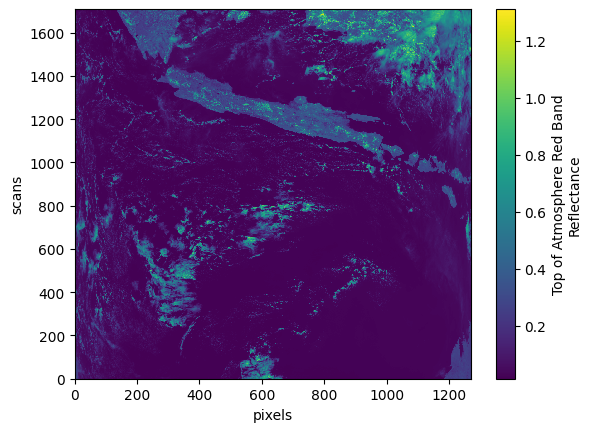

In [37]:
dataset = xr.open_datatree(l1b_paths[0])
dataset = xr.merge(dataset.to_dict().values())
dataset = dataset.set_coords(("longitude", "latitude"))
plot = dataset["rhot_red"].sel({"red_bands": 100}).plot()

## 3. Run `l2gen` with default configurations

Let's now run `l2gen` using its default configuration.

Before we do this, however, there is one additional step required to <i>exactly</i> replicate an L2 file from the OB.DAAC. The algorithms within `l2gen` require ancillary data such as meterological information, ozone concentrations, and sea surface temperatures. To use the corresponding ancillary data for the given date and region, we need to run the `getanc` OCSSW function. If `getanc` is not used, `l2gen` uses climatological data found in `share/common`.

We can run `getanc -h` to see options for the program:

In [38]:
!source {env}; getanc -h

/content/bin/seadasutils/anc_utils.py:703: SyntaxWarning: invalid escape sequence '\d'
  if re.search('[\d]{8}T', ancfile) or re.search('[\d]{14}', ancfile):
/content/bin/seadasutils/anc_utils.py:703: SyntaxWarning: invalid escape sequence '\d'
  if re.search('[\d]{8}T', ancfile) or re.search('[\d]{14}', ancfile):
/content/bin/seadasutils/anc_utils.py:704: SyntaxWarning: invalid escape sequence '\d'
  ymd = re.search('[\d]{8}', ancfile).group()
/content/bin/seadasutils/anc_utils.py:710: SyntaxWarning: invalid escape sequence '\d'
  elif re.search('[\d]{13}', ancfile):
/content/bin/seadasutils/anc_utils.py:711: SyntaxWarning: invalid escape sequence '\d'
  ymd = re.search('[\d]{7}', ancfile).group()
/content/bin/seadasutils/anc_utils.py:716: SyntaxWarning: invalid escape sequence '\d'
  elif re.search('[\d]{12}', ancfile):
/content/bin/seadasutils/anc_utils.py:717: SyntaxWarning: invalid escape sequence '\d'
  ymd = re.search('[\d]{8}', ancfile).group()
/content/bin/seadasutils/anc_util

Let's run it on our L1B file, using the `--use_filename` parameter to parse only the filename for datetime information.
We can parse the filename from `l1b_paths` to use with `{}` variable expansion after the `!` prefix like have done with `{env}` above.

In [39]:
#l1b_path = l1b_paths[0].full_name
l1b_path = l1b_paths[0]
l1b_path
l1b_name = Path(l1b_path).name
l1b_name

'PACE_OCI.20250429T054101.L1B.V3.nc'

In [40]:
!source {env}; getanc --use_filename {l1b_name} --ofile l2gen.anc --noprint

ancillary_data.db


You'll notice that a file named "l2gen.anc" now appears in your working directory. Reading this file, you can see that ancillary files are saved in the `var/anc/` directory.  Note that this file also provides text in the correct format for use in a par file.

In [41]:
!cat l2gen.anc

icefile=/content/var/anc/2025/119/20250429120000-CMC-L4_GHRSST-SSTfnd-CMC0.1deg-GLOB-v02.0-fv03.0.nc
met1=/content/var/anc/2025/119/GMAO_MERRA2.20250429T050000.MET.nc
met2=/content/var/anc/2025/119/GMAO_MERRA2.20250429T060000.MET.nc
met3=/content/var/anc/2025/119/GMAO_MERRA2.20250429T060000.MET.nc
ozone1=/content/var/anc/2025/119/GMAO_MERRA2.20250429T050000.MET.nc
ozone2=/content/var/anc/2025/119/GMAO_MERRA2.20250429T060000.MET.nc
ozone3=/content/var/anc/2025/119/GMAO_MERRA2.20250429T060000.MET.nc
sstfile=/content/var/anc/2025/119/20250429120000-CMC-L4_GHRSST-SSTfnd-CMC0.1deg-GLOB-v02.0-fv03.0.nc


Now, we'll make a par file that has an ifile, ofile, and latitude and longitude boundaries. Trust us ... subsetting the L1B file to a smaller region makes processing time faster for this demo!

We will output the Rrs variable by listing l2prod to "Rrs". And we wil also set proc_uncertainity to 0, which means we are not calculating uncertainites for Rrs. This makes `l2gen` process faster.

Let's first make a folder called 'data' to store the outputs:

In [42]:
data = Path("data")
data.mkdir(exist_ok=True)

Use the `write_par` function to create the following "l2gen.par" file in your current working directory.

In [ ]:
l1b_path

'/content/PACE_OCI.20250507T170659.L1B.V3.nc'

In [52]:
par = {
    "ifile": l1b_path,
    "ofile": data / l1b_name.replace("L1B", "L2"), #108.792114,-7.193551,111.725464,-5.676117
    "north": -5.676117,
    "south": -7.193551,
    "west": 108.792114,
    "east": 111.725464,
    "l2prod": "Rrs",
    "proc_uncertainty": 0,
}
write_par("l2gen.par", par)

Now, let's run l2gen using this new par file AND the ancillary information in the second par file generated by `getanc`. This can take several minutes.

In [50]:
#install this if not receive errro
!apt-get update -qq
!apt-get install -y attr


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
attr is already the newest version (1:2.5.1-1build1).
0 upgraded, 0 newly installed, 0 to remove and 60 not upgraded.


In [53]:
!source {env}; l2gen par=l2gen.par par=l2gen.anc

Loading default parameters from /content/share/common/msl12_defaults.par
Input file /content/PACE_OCI.20250429T054101.L1B.V3.nc is PACE L1B file.

Loading characteristics for OCI
Opening sensor information file /content/share/oci/msl12_sensor_info.dat
  Bnd   Lam       Fo    Tau_r     k_oz    k_no2    t_co2   awhite       aw      bbw
    0  314.550  112.329 4.880e-01 4.222e-01 3.282e-19 1.000e+00 0.000e+00 2.305e-01 6.356e-03
    1  316.239   92.673 6.491e-01 5.817e-01 2.960e-19 1.000e+00 0.000e+00 1.633e-01 7.727e-03
    2  318.262   85.208 7.410e-01 5.479e-01 2.844e-19 1.000e+00 0.000e+00 1.278e-01 8.187e-03
    3  320.303   82.100 7.807e-01 4.616e-01 2.833e-19 1.000e+00 0.000e+00 1.105e-01 8.271e-03
    4  322.433   80.692 7.906e-01 3.551e-01 2.898e-19 1.000e+00 0.000e+00 9.950e-02 8.190e-03
    5  324.649   86.329 7.916e-01 2.573e-01 3.019e-19 1.000e+00 0.000e+00 9.079e-02 8.041e-03
    6  326.828   95.925 7.891e-01 1.911e-01 3.132e-19 1.000e+00 0.000e+00 8.475e-02 7.871e-03
    7 

You'll know `l2gen` processing is finished successfully when you see "Processing Completed" at the end of the cell output.

Let's open up this new L2 data using XArray's open_datatree function:

In [54]:
dat

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

In [55]:
dat = xr.open_datatree(par["ofile"])
dat = xr.merge(dat.to_dict().values())
dat = dat.set_coords(("longitude", "latitude"))
dat

/tmp/ipython-input-4064943098.py:1: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  dat = xr.open_datatree(par["ofile"])
/tmp/ipython-input-4064943098.py:1: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decodi

<xarray.Dataset> Size: 41MB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 192,
                    pixels_per_line: 303)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 233kB ...
    latitude       (number_of_lines, pixels_per_line) float32 233kB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/25)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    clat           (number_of_lines) float32 768B ...
    elat           (number_of_lines) float32 768B ...
    csol_z         (number_of_lines) float32 768B ...
    Rrs            (number_of_lines, pixels_per_line, wavelength_3d) float32 40MB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 233kB ...
    tilt           (number_of_lines) float32 768B ...
Attributes: (12/47)
    title:                          OCI Level-2 Data OC
    product_name:                   PACE_OCI.20250429T054101.L2.V3.nc
    processing_version:             Unspecified
    history:                        l2gen par=l2gen.par par=l2gen.anc
    instrument:                     OCI
    platform:                       PACE
    ...                             ...
    geospatial_lon_min:             108.49463
    startDirection:                 Ascending
    endDirection:                   Ascending
    day_night_flag:                 Day
    earth_sun_distance_correction:  0.9860485792160034
    geospatial_bounds:              POLYGON ((-7.12319 112.03603, -7.78533 10...

Let's do a quick plot of Rrs at 550 nm:

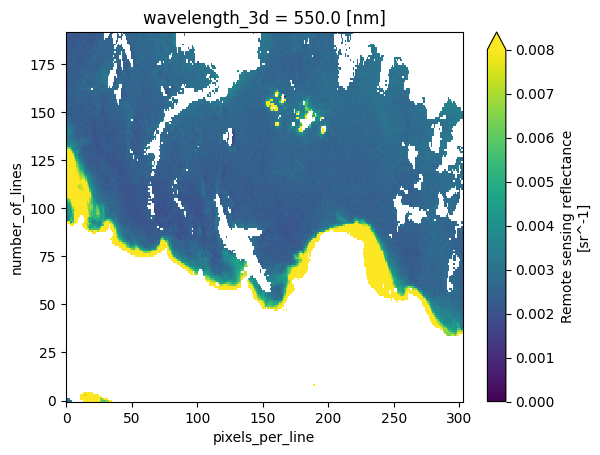

In [56]:
plot = dat["Rrs"].sel({"wavelength_3d": 550}).plot(vmin=0, vmax=0.008)

## 4. Compare the newly generated file with a standard OB.DAAC file

Remember the OB.DAAC L2 file we previously downloaded?  Let's see how it compares with the L2 file we generated ourselves.

Note, however, that the L2 file we downloaded includes the full granule, whereas our homegrown L2 file only includes the geographic bounding box of 35 to 39 N and -76 to -74.5 W. So, let's pause briefly to learn how to extract a geographic region from a L2 file. OCSSW provides the tools to do so and the process includes two steps.

First, we'll use the program `lonlat2pixline` to identify the scan line and pixel boundaries that correspond to our latitude and longitude coordinates within the full L2 granule.  Recall that you can see all the options for OCSSW programs by calling them without any arguments.

We need the full path to the input file (this will become the `$1` argument).

In [57]:
l2_path = l2_paths[0] #.full_name
l2_name = Path(l2_path).name
l2_sub_path = data / l2_name.replace("L2", "L2_sub")
l2_sub_path

PosixPath('data/PACE_OCI.20250429T054101.L2_sub.OC_AOP.V3_1.nc')

And we need to specify the bounding box in the standard order: west, south, east, north

In [64]:
pixline = !source {env}; lonlat2pixline {l2_path} 108.792114 -7.193551 111.725464 -5.676117 #-76.0 35.0 -74.5 39.0
pixline

['# 518 820 1223 1414', 'sline=1223', 'eline=1414', 'spixl=518', 'epixl=820']

In [65]:
_, spix, epix, sline, eline = pixline[0].split()

This output gets fed into `l2extract` to create a new, smaller file that only includes our defined geographic boundaries. The arguments are input file, start pixel, end pixel, start line, end line, sampling substep for pixels and lines (where 1 = every pixel), and output file.

In [66]:
!source {env}; l2extract

This is version 3.2 of l2extract (compiled on Aug 22 2025 03:38:27)
l2extract 3.2 (Aug 22 2025 03:38:04)
Usage: l2extract argument-list
   or: l2extract ifile spix epix sline eline pix_sub sc_sub ofile <prodlist>

  This program takes a product (or products if netCDF output) from an L2 file
  and does the extraction

  The argument list is a set of keyword=value pairs.  Arguments can
  be specified on the command line, or put into a parameter file, or the
  two methods can be used together, with command line overriding.

The list of valid keywords follows:

   help (boolean) (alias=h) (default=false) = print usage information
   version (boolean) (default=false) = print the version
        information
   dump_options (boolean) (default=false) = print
        information about each option
   dump_options_paramfile (ofile) = print
        information about each option to paramfile
   dump_options_xmlfile (ofile) = print
        information about each option to XML file
   par (ifile) = i

In [68]:
!source {env}; l2extract {l2_path} {spix} {epix} {sline} {eline} 1 1 {l2_sub_path}

This is version 3.2 of l2extract (compiled on Aug 22 2025 03:38:27)
No wavelength_3d list is supplied by the user. All wavelength 3D will be in output 
sscan: 1223  escan: 1414
spixl: 518  epixl: 820


This should have created a new file including "L2_sub" in the data subdirectory.

Let's open it and see how it compares with the L2 file we generated.

In [69]:
dat_sub = xr.open_datatree(l2_sub_path)
dat_sub = xr.merge(dat_sub.to_dict().values())
dat_sub = dat_sub.set_coords(("longitude", "latitude"))
dat_sub

/tmp/ipython-input-3150145366.py:1: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  dat_sub = xr.open_datatree(l2_sub_path)
/tmp/ipython-input-3150145366.py:1: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue dec

<xarray.Dataset> Size: 82MB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 192,
                    pixels_per_line: 303)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 233kB ...
    latitude       (number_of_lines, pixels_per_line) float32 233kB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/30)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    aot_865        (number_of_lines, pixels_per_line) float32 233kB ...
    angstrom       (number_of_lines, pixels_per_line) float32 233kB ...
    avw            (number_of_lines, pixels_per_line) float32 233kB ...
    nflh           (number_of_lines, pixels_per_line) float32 233kB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 233kB ...
    tilt           (number_of_lines) float32 768B ...
Attributes: (12/47)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20250429T054101.L2.OC_AOP.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data9/sdpsoper/vdc/vpu28/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                108.49463
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9860490560531616
    geospatial_bounds:                 POLYGON ((120.99629 -0.25618, 97.25328...

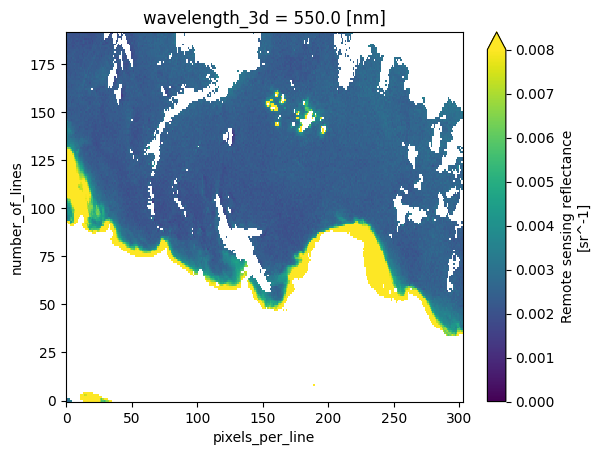

In [70]:
plot = dat_sub["Rrs"].sel({"wavelength_3d": 550}).plot(vmin=0, vmax=0.008)

The two maps of Rrs(550) look extremely similar.  But, let's compare the data in a scatter plot to be sure.

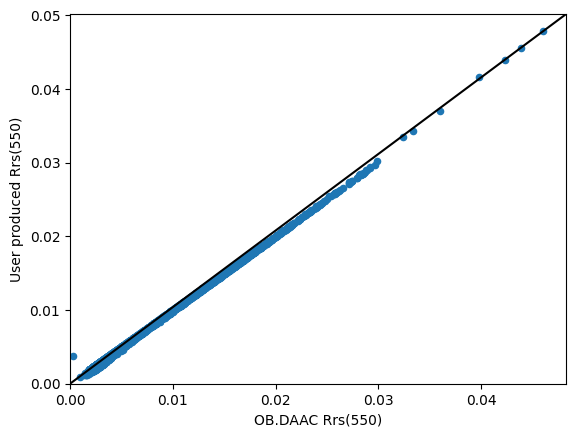

In [71]:
fig, ax = plt.subplots()

x = dat["Rrs"].sel({"wavelength_3d": 550})
y = dat_sub["Rrs"].sel({"wavelength_3d": 550})

ax.scatter(x, y, s=20)
ax.set_xlabel("OB.DAAC Rrs(550)")
ax.set_ylabel("User produced Rrs(550)")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black")
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

plt.show()

Other than a negligible number of oddball points, the data are identical. This shows that an end-user can exactly reproduce the data distributed by the OB.DAAC!

## 5. Run l2gen with modifications to configurations

### Selecting biogeochemical data products

Let's say you want to run `l2gen` to retrieve biogeochemical data products, such as chlorophyll a concentrations. There are two ways to do so. First, you can assign a specific product suite.  For chlorophyll, this is done by adding "suite=BGC" to your .par file.  Second, you can explicitly define your output products in a list using the "l2prod" keyword. Consider this example:

<pre>l2prod=Rrs,chlor_a,poc,l2flags</pre>

"Rrs" includes all Rrs wavelengths, "chlor_a" is chlorophyll-a, "poc" is particulate organic carbon, and "[l2flags][l2flags]" is the bitwise operator that identifies processing flags assigned to each pixel (you <b>always</b> want to include [l2flags][l2flags] as an output product!).

Tip: You can run `get_product_info l sensor=oci` to see the many many products l2gen can produce.


Let's write a new .par file named "l2gen_mod.par" to define the L2 products listed above and rerun `l2gen`.

[l2flags]: https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/

In [72]:
!source {env}; get_product_info l sensor=oci

bbp_nnn_mgiop
bbp_nnn_las
bbp_nnn_pml
bbp_nnn_qaa
bbp_nnn_carder
bbp_nnn_giop
bbp_nnn
bbp
bbp_gsm
bbp_nnn_gsm
bbp_soa
bbp_sma
bbp_nnn_swim
aph_nnn_mgiop
aph_nnn_pml
aph_nnn_qaa
aph_carder
aph_nnn_carder
aph_nnn_giop
aph_nnn
aph
aph_nnn_gsm
aph_nnn_swim
adg_nnn_mgiop
adg_nnn_pml
adg_nnn_qaa
adg_carder
adg_nnn_carder
adg_nnn_giop
adg_nnn
adg
adg_gsm
adg_nnn_gsm
adg_soa
adg_sma
adg_nnn_morel
adg_nnn_swim
npix_mgiop
crat_mgiop
fit_par_nnn_mgiop
fit_par_nnn_giop
chla_mapol
chl_oc2
chl_oc3
chl_oc3c
chl_oc4
chl_hu
chl_oci2
chl_oci
chlor_a
chl_cdr
chl_cdomcorr_morel
chl_carder
chl_carder_empirical
chl_giop
chl_gsm
chl_soa
chl_sma
chl_morel
chl_vc
chl_mgiop
chl_swim
chl_abi
chl_mph
Lt_nnn
Lt
Lt_unc_nnn
BT_nnn
nw
nw_nnn
aw
aw_nnn_tscor
bbw
bbw_nnn_tscor
a_nnn_las
a_nnn_pml
a_nnn_qaa
a_nnn_carder
a_nnn_giop
a_nnn
a
a_nnn_gsm
a_nnn_niwa
a_nnn_swim
bb_nnn_las
bb_nnn_pml
bb_nnn_qaa
bb_nnn_carder
bb_nnn_giop
bb_nnn
bb
bb_nnn_gsm
bb_nnn_niwa
bb_nnn_swim
b_nnn_las
c_nnn_las
bbp_s_las
bbp_s_giop
bbp_s
b

In [82]:
par = {
    "ifile": l1b_path,
    "ofile": data / l1b_name.replace("L1B", "L2_mod"),
    "l2prod": "Rrs,chlor_a,poc,l2_flags", #,cdom_index,microplankton_hirata,abundance_micro_ksm,carbon_phyto,carbon_phyto_unc
    "north": -5.676117, #108.792114 -7.193551 111.725464 -5.676117
    "south": -7.193551,
    "west": 108.792114,
    "east": 111.725464,
}
write_par("l2gen_mod.par", par)

In [92]:
!source {env}; l2gen par=l2gen_mod.par par=l2gen.anc

Loading default parameters from /content/share/common/msl12_defaults.par
Input file /content/PACE_OCI.20250429T054101.L1B.V3.nc is PACE L1B file.

Loading characteristics for OCI
Opening sensor information file /content/share/oci/msl12_sensor_info.dat
  Bnd   Lam       Fo    Tau_r     k_oz    k_no2    t_co2   awhite       aw      bbw
    0  314.550  112.329 4.880e-01 4.222e-01 3.282e-19 1.000e+00 0.000e+00 2.305e-01 6.356e-03
    1  316.239   92.673 6.491e-01 5.817e-01 2.960e-19 1.000e+00 0.000e+00 1.633e-01 7.727e-03
    2  318.262   85.208 7.410e-01 5.479e-01 2.844e-19 1.000e+00 0.000e+00 1.278e-01 8.187e-03
    3  320.303   82.100 7.807e-01 4.616e-01 2.833e-19 1.000e+00 0.000e+00 1.105e-01 8.271e-03
    4  322.433   80.692 7.906e-01 3.551e-01 2.898e-19 1.000e+00 0.000e+00 9.950e-02 8.190e-03
    5  324.649   86.329 7.916e-01 2.573e-01 3.019e-19 1.000e+00 0.000e+00 9.079e-02 8.041e-03
    6  326.828   95.925 7.891e-01 1.911e-01 3.132e-19 1.000e+00 0.000e+00 8.475e-02 7.871e-03
    7 

A new L2 file should have appeared in your data folder.  Let's open it using XArray again and plot the chlorophyll-a product:

In [85]:
!pip install h5netcdf scipy

In [86]:
import xarray as xr

/tmp/ipython-input-584424037.py:1: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  dat_mod = xr.open_datatree(par["ofile"])
/tmp/ipython-input-584424037.py:1: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue deco

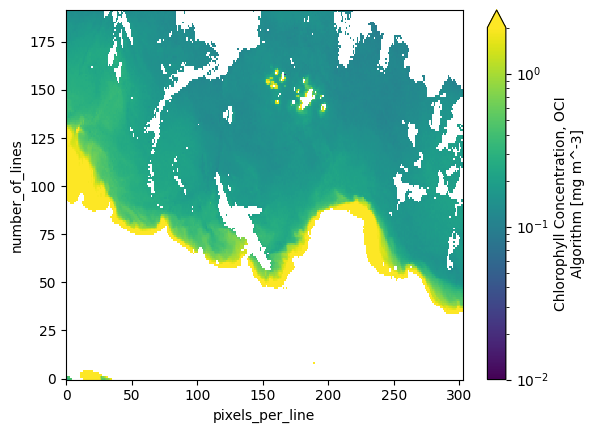

In [93]:
dat_mod = xr.open_datatree(par["ofile"])
dat_mod = xr.merge(dat_mod.to_dict().values())
dat_mod = dat_mod.set_coords(("longitude", "latitude"))
plot = dat_mod["chlor_a"].plot(norm=LogNorm(vmin=0.01, vmax=2))

For fun, let's plot chlor_a again, but with some additional plotting functions.

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


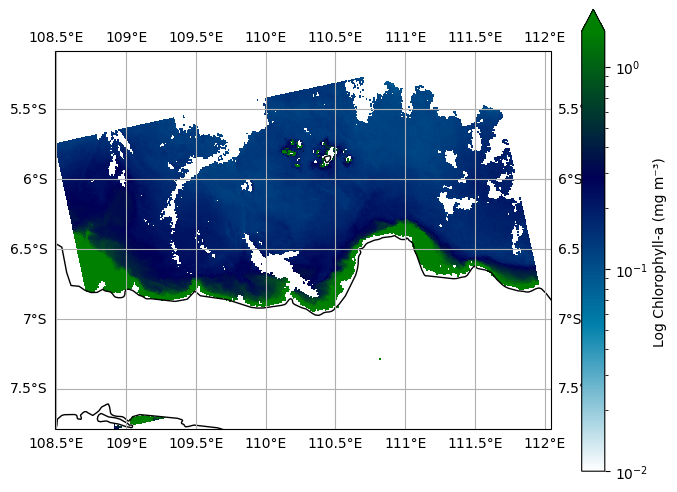

In [94]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})

dat_mod["chlor_a"].plot(
    ax=ax,
    x="longitude",
    y="latitude",
    transform=ccrs.PlateCarree(),
    cmap="ocean_r",
    norm=LogNorm(vmin=0.01, vmax=1.5),
    cbar_kwargs={"label": "Log Chlorophyll-a (mg m⁻³)"},
)

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True)

plt.show()

### Disabling BRDF correction

As a final example of the far-reaching utility that `l2gen` provides an end user, let's exercise one more example where we disable the standard bidirectional reflectance distribution function (BRDF) correction and see how it changes the retrieved Rrs values. The default BRDF is 'brdf_opt=7', which is Morel f/Q + Fresnel solar + Fresnel sensor.

While a rather simple case-study, we hope it will introduce the practioner to an improved understanding of `l2gen` and the sensitivity of derived reflectances (and, therefore, biogeochemical variables) to choices made within the standard processing scheme.

In [98]:
par = {
    "ifile": l1b_path,
    "ofile": data / l1b_name.replace("L1B", "L2_brdf"),
    "l2prod": "Rrs,chlor_a,poc,l2_flags",
    "brdf_opt": 0,
       "north": -5.676117, #108.792114 -7.193551 111.725464 -5.676117
    "south": -7.193551,
    "west": 108.792114,
    "east": 111.725464,
}
write_par("l2gen_brdf.par", par)

In [99]:
!source {env}; l2gen par=l2gen_brdf.par par=l2gen.anc

Loading default parameters from /content/share/common/msl12_defaults.par
Input file /content/PACE_OCI.20250429T054101.L1B.V3.nc is PACE L1B file.

Loading characteristics for OCI
Opening sensor information file /content/share/oci/msl12_sensor_info.dat
  Bnd   Lam       Fo    Tau_r     k_oz    k_no2    t_co2   awhite       aw      bbw
    0  314.550  112.329 4.880e-01 4.222e-01 3.282e-19 1.000e+00 0.000e+00 2.305e-01 6.356e-03
    1  316.239   92.673 6.491e-01 5.817e-01 2.960e-19 1.000e+00 0.000e+00 1.633e-01 7.727e-03
    2  318.262   85.208 7.410e-01 5.479e-01 2.844e-19 1.000e+00 0.000e+00 1.278e-01 8.187e-03
    3  320.303   82.100 7.807e-01 4.616e-01 2.833e-19 1.000e+00 0.000e+00 1.105e-01 8.271e-03
    4  322.433   80.692 7.906e-01 3.551e-01 2.898e-19 1.000e+00 0.000e+00 9.950e-02 8.190e-03
    5  324.649   86.329 7.916e-01 2.573e-01 3.019e-19 1.000e+00 0.000e+00 9.079e-02 8.041e-03
    6  326.828   95.925 7.891e-01 1.911e-01 3.132e-19 1.000e+00 0.000e+00 8.475e-02 7.871e-03
    7 

A new L2 file should have appeared in your data folder.  Let's open it using XArray again and plot Rrs(550):

In [100]:
dat_brdf = xr.open_datatree(par["ofile"])
dat_brdf = xr.merge(dat_brdf.to_dict().values())
dat_brdf = dat_brdf.set_coords(("longitude", "latitude"))
dat_brdf

/tmp/ipython-input-3357255595.py:1: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  dat_brdf = xr.open_datatree(par["ofile"])
/tmp/ipython-input-3357255595.py:1: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue d

<xarray.Dataset> Size: 41MB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 192,
                    pixels_per_line: 303)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 233kB ...
    latitude       (number_of_lines, pixels_per_line) float32 233kB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/27)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    csol_z         (number_of_lines) float32 768B ...
    Rrs            (number_of_lines, pixels_per_line, wavelength_3d) float32 40MB ...
    chlor_a        (number_of_lines, pixels_per_line) float32 233kB ...
    poc            (number_of_lines, pixels_per_line) float32 233kB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 233kB ...
    tilt           (number_of_lines) float32 768B ...
Attributes: (12/47)
    title:                          OCI Level-2 Data OC
    product_name:                   PACE_OCI.20250429T054101.L2_brdf.V3.nc
    processing_version:             Unspecified
    history:                        l2gen par=l2gen_brdf.par par=l2gen.anc
    instrument:                     OCI
    platform:                       PACE
    ...                             ...
    geospatial_lon_min:             108.49463
    startDirection:                 Ascending
    endDirection:                   Ascending
    day_night_flag:                 Day
    earth_sun_distance_correction:  0.9860485792160034
    geospatial_bounds:              POLYGON ((-7.12319 112.03603, -7.78533 10...

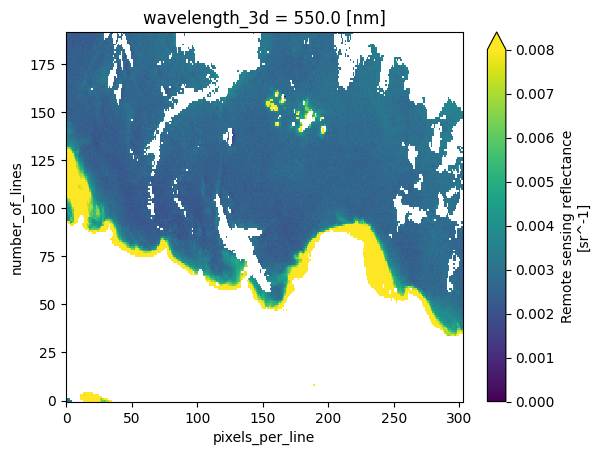

In [103]:
dat_brdf["Rrs"].sel({"wavelength_3d": 550}).plot(vmin=0, vmax=0.008)

This figure looks similar to what we produced in Section 3, but let's make a scatter plot to be sure ...

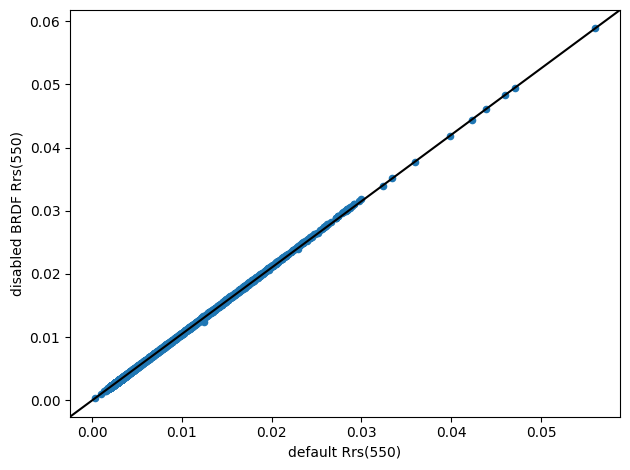

In [104]:
fig, ax = plt.subplots()

x = dat_mod["Rrs"].sel({"wavelength_3d": 550})
y = dat_brdf["Rrs"].sel({"wavelength_3d": 550})


ax.scatter(x, y, s=20)
ax.set_xlabel("default Rrs(550)")
ax.set_ylabel("disabled BRDF Rrs(550)")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black")

plt.tight_layout()
plt.show()

You can see that disabling the BRDF does in fact change Rrs values.

<div class="alert alert-info" role="alert">

You have completed the notebook on "Running the Level-2 Generator (l2gen) OCSSW program on OCI data". We suggest looking at the notebook on "Running l2gen's Generalized Inherent Optical Property (GIOP) model on OCI data" tutorial to learn more about deriving IOP products from PACE OCI data.

</div>